# Mortos no massacre de Gaza - 2023-2024
## Exploração e limpeza dos dados

Esse notebook faz parte do tutorial sobre as mortes de palestinos no ataque de Israel a Gaza após o ataque do Hamas
em 7 de outubro de 2023.

Neste notebook, realizamos a exploração e tratamento dos dados antes de prosseguir ao ajuste de um modelo estatístico 
utilizando o método de Monte Carlo com Cadeias de Markov ([MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo), 
em inglês). O ajuste é feito no notebook:
[10_ajuste-modelo_MCMC_mortos-gaza.ipynb](10_ajuste-modelo_MCMC_mortos-gaza.ipynb)

In [48]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import sys
import json

sys.path.append("../80_material-complementar/")
import auxiliar.dataframes as ad
import auxiliar.graficos as ag

## Carrega os dados

O site [techforpalestine.org](https://data.techforpalestine.org) disponibiliza três tipos de dados a respeito das mortes em Gaza. Vamos carregá-los aqui:

**Resumo geral** - Apenas o total de mortes acumulado (pegamos os dados no dia 21/02/2024): 

In [2]:
# Resumo geral (total de mortos) por categoria (e.g. mulheres, crianças):
with open('dados/summary.json', 'r') as f:
    summary_data = json.load(f)
summary_data

{'killedInGazaListCount': 14140,
 'massacres': 2554,
 'killed': {'total': 29313,
  'children': 12660,
  'women': 8570,
  'civilDefence': 46,
  'press': 130,
  'medical': 340},
 'injured': {'total': 69333},
 'dailyReportCount': 138,
 'lastDailyUpdate': '2024-02-21'}

Segundo o site, os dados acima são uma agregação dos dados a seguir.

**Contagem diária** - Quantidade de pessoas mortas por dia, dentro de algumas categorias. Segundo o site, as fontes dessas informações são três:
* [Gaza's Ministry of Health Telegram channel](https://t.me/s/MOHMediaGaza)
* [Gaza's Government Media Office Telegram channel](https://t.me/s/mediagovps)
* Sem registro (não ficou claro da onde esses dados vem)

In [3]:
# Contagem de mortos por data e categoria:
casual_df = pd.read_csv('dados/casualties_daily.csv')
casual_df['report_date'] = pd.to_datetime(casual_df['report_date'])
casual_df.head()

,report_date,report_source,ext_massacres_cum,killed,killed_cum,ext_killed,ext_killed_cum,ext_killed_children_cum,ext_killed_women_cum,injured_cum,ext_injured,ext_injured_cum,ext_civdef_killed_cum,med_killed_cum,ext_med_killed_cum,press_killed_cum,ext_press_killed_cum
0,2023-10-07,mohtel,0,232,232,232,232,0,0,1610,1610,1610,0.0,6.0,6.0,1.0,1.0
1,2023-10-08,mohtel,0,138,370,138,370,78,41,1788,178,1788,0.0,6.0,1.0,1.0,NaN
2,2023-10-09,mohtel,8,190,560,190,560,91,61,2271,483,2271,0.0,6.0,6.0,3.0,3.0
3,2023-10-10,mohtel,8,340,900,340,900,260,230,4000,1729,4000,0.0,6.0,7.0,7.0,NaN
4,2023-10-11,gmotel,23,200,1100,200,1100,398,230,5184,1184,5184,0.0,10.0,10.0,7.0,NaN


**Pessoas mortas identificadas em hospitais** - Lista com os nomes, data de nascimento, idade e sexo de pessoas mortas e identificadas em hospitais. Segundo o site, a última atualização foi em 5 de janeiro para hospitais que reportam do Sul de Gaza e 2 de novembro para os que reportam do Norte. Além disso, para essa lista:
* As pessoas desaparecidas e os corpos dos que ficaram presos sob os escombros não foram contabilizados.
* As pessoas não identificadas que chegaram aos hospitais não foram contabilizadas.
* As pessoas não identificadas cujos corpos foram entregues pela ocupação israelense não foram contabilizadas.
* Não foram contabilizados aqueles que foram enterrados por suas famílias sem passar pelos hospitais.
* As vítimas em Gaza e no Norte de Gaza não foram contabilizadas após a data de encerramento do sistema de informação em Novembro.

In [4]:
# Pessoas mortas e identificadas em hospitais:
nomes_df = pd.read_json('dados/killed-in-gaza.json')

Por ser mais detalhado e ter sido produzido pelos hospitais, esses dados são potencialmente mais confiáveis. 

### Confiabilidade dos dados

Segundo a reportagem 
[Quantos palestinos morreram em Gaza? Explicação do número de mortos](https://www.reuters.com/world/middle-east/how-many-palestinians-have-died-gaza-war-how-will-counting-continue-2023-12-06/)
da Agência Reuters:

"Antes da guerra, Gaza tinha estatísticas populacionais robustas e sistemas de informação de saúde que funcionavam bem, melhores do que na maioria dos países do Oriente Médio, disseram especialistas em saúde pública à Reuters. Oona Campbell, professora da Escola de Higiene e Medicina Tropical de Londres, disse que as autoridades de saúde palestinas têm credibilidade de longa data com os seus métodos de manutenção de estatísticas de base e de rastreio de mortes em geral, não apenas durante tempos de guerra. As agências da ONU confiam nos números.

'As capacidades de recolha de dados palestinos são profissionais e muitos funcionários do ministério foram treinados nos Estados Unidos. Eles trabalham arduamente para garantir a fidelidade estatística', disse Nathaniel Raymond, da Universidade de Yale.

Em 26 de outubro, o Ministério da Saúde da AP publicou um relatório de 212 páginas com os nomes, idades e números de identificação de 7.028 palestinos registrados como mortos em ataques aéreos – depois que o presidente dos EUA, Joe Biden, lançou dúvidas sobre o número de vítimas.
Campbell e dois outros acadêmicos [analisaram os dados do relatório para a revista médica Lancet](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(23)02640-5/fulltext), 
em 26 de novembro, e concluíram que não havia razão óbvia para duvidar de sua validade. 'Consideramos implausível que estes padrões (de taxas de mortalidade) surjam da fabricação de dados', 
escreveram os pesquisadores." [Segundo a revista médica The Lancet](https://www.thelancet.com/journals/lancet/article/PIIS0140-6736(24)01169-3/fulltext), uma série de outras verificações ratificaram que os dados são confiáveis.

### Significado dos dados

#### Significado do termo "criança"

* Segundo a [mesma reportagem da Reuters](https://www.reuters.com/world/middle-east/how-many-palestinians-have-died-gaza-war-how-will-counting-continue-2023-12-06/), 
crianças são pessoas com menos de 18 anos.

## Exploração dos dados

Vamos realizar uma série de verificações nos dados (especialmente da lista com nomes, idade e sexo dos mortos) para entender seu significado e para limpar eventuais erros.

### Pessoas repetidas

Vamos verificar se a coluna `id` identifica uma pessoa morta de maneira única:

In [5]:
# Quantidade de IDs:
nomes_df['id'].nunique() == len(nomes_df)

True

Vamos buscar por pessoas com nome, sexo e data de nascimento (_date of birth_) `dob` repetidos, que podem indicar duplicidade nos dados:

In [6]:
repeticoes = nomes_df.drop('id', axis=1).value_counts()
repeticoes.name = 'repetições'
repeticoes.loc[repeticoes > 1].reset_index()

,name,age,dob,sex,en_name,repetições
0,مجهول,24,2000-01-01,m,?,13
1,مجهول مجهول مجهول مجهول,-1,,m,? ? ? ?,5
2,مؤمن كمال احمد سعيد,-1,,m,Momin Kamal Ahmed Saeed,2
3,احمد ابراهيم بدوان,-1,,m,Ahmed Ibrahem Badwan,2
4,هاله سليمان محمد النباهين,24,2000-01-01,f,Halah Suleiman Muhammad al-Nabahin,2
5,كريم محمد نبيل القشاوي,25,1999-01-01,m,Kariam Muhammad Nabil Aliqshaoi,2
6,محمد رامي احمد اسماعيل,-1,,m,Muhammad Rami Ahmed Ismail,2
7,احمد محمد حسن الزعزوع,-1,,m,Ahmed Muhammad Hassan Alzazoa,2
8,حنين عوني فايز الاشقر,26,1997-07-13,f,Hanin Aoni Fayez Alishqur,2
9,مجهول مجهول مجهول مجهول,34,1990-01-01,m,? ? ? ?,2


Vemos que existem repetições de alguns registros. Também notamos que:
* Grande parte dos registros duplicados são de pessoas sem identificação (? na coluna `en_name`, nome em inglês) e com nome em árabe (coluna `name`) com o termo "مجهول", que significa "Anônimo".
* Boa parte dessas repetições não possuem data de nascimento (e, portanto, nem idade), o que pode indicar incerteza quanto à sua identificação.
* Vários dos registros, inclusive os anônimos, apresentam uma data de nascimento de **1 de janeiro**. Isso indica que **essas datas foram preenchidas no chute**.

Erros desse tipo são comuns em dados reais, que são sujos. Seria estranho se todos os dados fossem bonitinhos, o que poderia denotar sua fabricação por um código de computador, por exemplo. Ademais, essa quantidade de dados errados é pequena em comparação com o tamanho da lista:

In [7]:
# Total de casos repetidos:
repeticoes.loc[repeticoes > 1].sum()

42

In [8]:
# Total de nomes na lista:
len(nomes_df)

14140

### Traduções equivocadas

Vamos verificar se a relação entre nomes em árabe e os traduzidos para inglês faz sentido.
Primeiro, vamos verificar se temos nomes árabes repetidos (podem ser homônimos ou dados duplicados) que foram traduzidos de forma diferente para o inglês. Se isso existir, poderíamos estar deixando de identificar uma duplicidade por causa de um erro de tradução.

In [10]:
# Nomes árabes com mais de um nome em inglês associado:
ad.one2oneViolations(nomes_df, 'name', 'en_name')

Series([], Name: en_name, dtype: object)

Não identificamos nenhum nome árabe com mais de uma grafia em inglês. Isso significa que o nome em árabe melhor identifica as pessoas que os nomes em inglês.

Agora, vamos ver se nomes árabes diferentes caíram na mesma grafia em inglês. Na lista abaixo, nomes em árabe estão separados por uma barra "`/`":

In [11]:
# CONTRÁRIO: nomes em inglês com mais de um nome árabe associado:
ad.print_array_series(ad.one2oneViolations(nomes_df, 'en_name', 'name'))

Abdalrahamun Ahmed Ibrahem Asqula: عبدالرحمن احمد ابراهيم عسقول / عبدالرحمن أحمد ابراهيم عسقول
Ahmed Muain Mahmoud Aiish: احمد معين محمود عياش / أحمد معين محمود عياش
Ahmed Muhammad Hassan Alzazoa: احمد محمد حسن الزعزوع / أحمد محمد حسن الزعزوع
Ahmed Rami Ahmed Ismail: احمد رامي احمد اسماعيل / احمد رامي أحمد اسماعيل
Ahmed Saeed Ismail Alshikh Ali: احمد سعيد اسماعيل الشيخ علي / أحمد سعيد اسماعيل الشيخ علي
Alaa Atef Taha Khidr: علا عاطف طه خضر / الاء عاطف طه خضر
Ayah Allah Ali Hassan Abbas: ايه الله علي حسن عباس / اية الله علي حسن عباس
Dana Eyad Ibrahem Abu-hamdah: دانا اياد ابراهيم ابوحامدة / دانا اياد ابراهيم ابوحامده
Fajr Asaad Abdal-majid Shhadah: فجر اسعد عبدالمجيد شحاده / فجر اسعد عبدالمجيد شحادة
Fatima Ahmed Mahmoud Abbas: فاطمة احمد محمود عباس / فاطمه احمد محمود عباس
Hamid Ahmed Hassan Ismail: حامد احمد حسن اسماعيل / حامد أحمد حسن اسماعيل
Hoor Hazm Ahmed al-Madhoun: حور حازم احمد المدهون / حور حازم أحمد المدهون
Isalam Asaad Abdal-majid Shhadah: اسلام اسعد عبدالمجيد شحاده / اسلام اس

Se olharmos os nomes árabes, veremos que eles se diferenciam por pequenos detalhes. Isso indica que o inglês não é capaz de traduzir de maneira única os nomes árabes. Seria como traduzir "Jéssica" e "Jessica" para o inglês: ficaria tudo "Jessica".

### Recortes dos dados

Para entender outros aspectos da lista com nomes e idades dos mortos, vamos criar subamostras da lista separando-a entre os registros com idade e os sem idade. 
Os com idade também serão separados entre homens e mulheres:

In [12]:
# Com todas as datas de nascimento:
com_idade_df = nomes_df.query('age != -1')
# Sem datas de nascimento:
sem_idade_df = nomes_df.query('age == -1')
# Por sexo:
m_com_idade_df = com_idade_df.query('sex == "m"')
f_com_idade_df = com_idade_df.query('sex == "f"')

Estamos interessados nos dados da lista de nomes pois esses têm informação sobre a idade, ao contrário dos demais dados do site [techforpalestine.org](https://data.techforpalestine.org).
Entretanto, esses dados têm alguns registros sem idade. Vamos verificar se existem indícios de que os dados sem idade têm alguma diferença sistemática em relação aos dados com idade. Para is

Estamos interessados nos dados que apresentam a idade dos mortos. Então, pretendemos excluir os dados sem idade. Primeiro, vamos verificar se esses dados são uma parcela pequena do total, de maneira a afetar pouco nossa análise posterior:

In [18]:
# Quantidade sem idade:
n_sem_idade = len(sem_idade_df)
print('Das {:,} pessoas na lista, {:} ({:.1f}%) não tem registro de idade'.format(len(nomes_df), n_sem_idade, n_sem_idade / len(nomes_df) * 100))

Das 14,140 pessoas na lista, 997 (7.1%) não tem registro de idade


Não temos muitos dados sem data de nascimento, então achamos que tudo ignorá-los. Especialmente se eles estiverem distribuídos de maneira equilibrada entre homens e mulheres.

#### Compatibilidade entre dados com e sem idade

Vamos verificar se os dados sem idade estão distribuídos por sexo de uma forma diferente dos dados com idade. Se estiverem, removê-los pode introduzir um viés nos dados:

In [23]:
# Fração dos dados em cada sexo, COM IDADE:
com_idade_df['sex'].value_counts(normalize=True)

sex
m    0.568135
f    0.431865
Name: proportion, dtype: float64

In [24]:
# Fração dos dados em cada sexo, SEM IDADE:
sem_idade_df['sex'].value_counts(normalize=True)

sex
m    0.5667
f    0.4333
Name: proportion, dtype: float64

**Conclusão:** não parece haver viés de sexo na ausência de idade.

### Compatibilidade entre resumo e informações detalhadas

#### Mulheres

Uma dúvida que surge é se o termo "mulher", quando usado em contabilização de mortes, se refere a pessoas do sexo feminino 
(incluindo crianças) ou se apenas se refere a mulheres adultas (com 18 anos ou mais). Vamos comparar os dados da lista detalhada com o de total de mortes acumuladas para tirar essa dúvida:

**Dados da lista detalhada**

In [25]:
# Dentre os com idade, seleciona adultos:
nomes_adultos_df  = com_idade_df.query('age >= 18')
# Seleciona mulheres adultas:
nomes_mulheres_adultas_df = nomes_adultos_df.query('sex == "f"')

In [26]:
# Fração dos adultos que são mulheres:
len(nomes_mulheres_adultas_df) / len(nomes_adultos_df)

0.410609507843372

In [29]:
# Fração de pessoas do sexo feminino, incluindo crianças:
len(com_idade_df.query('sex == "f"')) / len(com_idade_df)

0.4318648710340105

Em qualquer definição de mulher, a fração que elas compõem entre os mortos é de uns 42%.

In [34]:
# Fração de mulheres adultas sobre o total de mortos:
len(nomes_mulheres_adultas_df) / len(com_idade_df)

0.26089933805067334

Já as mulheres adultas correspondem a aproximadamente 1/4 do total de mortes.

**Dados acumulados**

In [31]:
# Pega dados sobre total de mortos:
total_mortos = summary_data['killed']
total_mortos

{'total': 29313,
 'children': 12660,
 'women': 8570,
 'civilDefence': 46,
 'press': 130,
 'medical': 340}

In [32]:
# Fração das chamadas "mulheres" sobre os adultos:
tot_mulheres = total_mortos['women']
tot_mulheres / (total_mortos['total'] - total_mortos['children'])

0.5146219900318261

In [33]:
# Fração das mulheres sobre a população total:
tot_mulheres / (total_mortos['total'])

0.2923617507590489

Os números acima são mais condizentes com a ideia de que "mulheres" se refere a pessoas adultas do sexo masculino, que é um conjunto menor do que se "mulheres" se referisse a todas
as pessoas do sexo feminino. 

**Conclusão:**

1. A categoria "mulheres" só inclui pessoas com 18 anos ou mais; "crianças" é um bloco só, não são discriminadas por sexo.
2. Entre pessoas mortas não identificadas (dados agregados) existe uma proporção maior de mulheres. Isso significa que, se utilizarmos a lista de nomes para avaliar se muitas mulheres foram mortas,
estaremos sendo conservadores, isto é, possivelmente subestimando esse valor.

#### Crianças

Vamos comparar a fração de crianças mortas na lista com pessoas identificadas com a contagem acumulada. A primeira fonte de dados (lista com nomes) possivelmente é mais precisa, 
mas também é mais desatualizada.

In [37]:
# Calcula fração de crianças na lista com nomes:
n_nomes_menores = (com_idade_df['age'] < 18).sum()
n_nomes_idade   = len(com_idade_df)
n_nomes_menores / n_nomes_idade

0.3646047325572548

Será importante saber o quanto que a fração acima poderia ter variado por puro acaso (flutuação estatística). 
Para isso, podemos considerar que o número de crianças entre o total da lista segue uma distribuição Binomial. Nesse caso, o desvio padrão é dado por:

$$\sigma = \sqrt{np(1-p)},$$

onde $n$ é o total de pessoas na lista e $p$ é a probabilidade de uma pessoa ser uma criança. Vamos simplificar essa conta ao mesmo tempo em que superestimamos o desvio padrão, e vamos considerar 
$\sigma = \sqrt{np} \simeq \sqrt{n_{\mathrm{crianças}}}$.

In [16]:
# Estimativa da flutuação estatística na fração:
np.sqrt(n_nomes_menores) / n_nomes_idade

0.005267007015103639

In [17]:
# Fração de crianças nos dados agregados:
total_mortos['children'] / total_mortos['total']

0.43189028758571285

**Conclusão:** entre pessoas mortas não identificadas (lista agregada), existe uma proporção significativamente maior de crianças. Se usarmos a lista com nomes na análise, estaremos sendo
conservadores com relação a essa quantidade.

## Distribuição por idade e sexo

Nas análises seguintes, vamos utilizar a lista de nomes como fonte de dados, apesar de desatualizada 
(segundo o site [techforpalestine.org](https://data.techforpalestine.org), a última atualização foi em 5 de janeiro 
de 2024 para hospitais do sul de Gaza e 2 de novembro para hospitais no norte). Faremos isso porque:
1. Essa lista contém a idade das pessoas, que é uma informação importante.
2. Em relação às contagens acumuladas, essa lista subestima o número de crianças e mulheres, o que reduz
nossa probabilidade de concluir, erroneamente, que existe um alto número dessas pessoas sendo mortas.

Então, vamos criar uma tabela com o número de mortes por sexo (colunas) e idade (linhas) a partir das listas de nomes:

In [59]:
# Contabilizando mortes por sexo e idade na lista de nomes:
m_nomes_por_idade = m_com_idade_df['age'].value_counts().sort_index()
f_nomes_por_idade = f_com_idade_df['age'].value_counts().sort_index()
nomes_por_idade_df = pd.DataFrame()
nomes_por_idade_df['homens'] = m_nomes_por_idade
nomes_por_idade_df['mulheres'] = f_nomes_por_idade
nomes_por_idade_df.fillna(0, inplace=True)

vamos visualizar esses dados no gráfico:

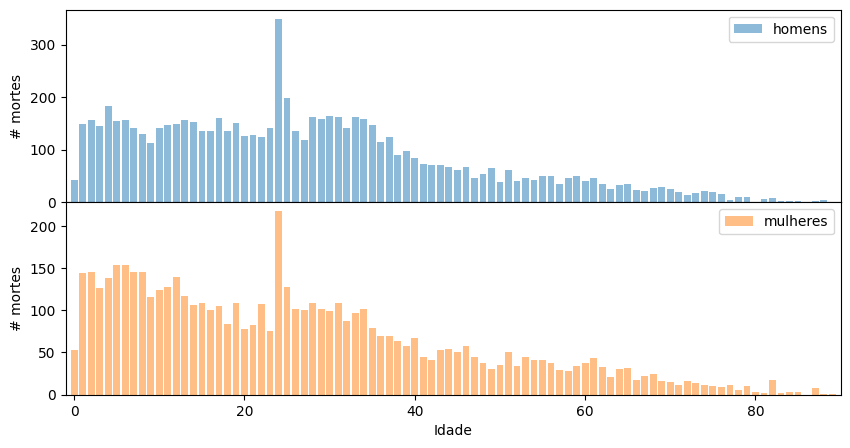

In [60]:
# Gráfico das mortes por idade (eixo x) e sexo (painel de cima e de baixo):
pl.figure(figsize=(10,5))
ag.graf_barra_2(nomes_por_idade_df, ylabel='# mortes')
pl.xlabel('Idade')
pl.show()

Identificamos no gráfico acima um pico esquisito na idade de 24 anos. Vamos tentar entender o que está acontecendo:

In [62]:
# Contabiliza pessoas de 24 anos por dia de aniversário:
com_idade_df.query('age == 24')['dob'].value_counts()

dob
2000-01-01    320
2000-02-02     18
1999-11-11      8
1999-12-21      4
2000-02-01      4
             ... 
1999-12-30      1
2000-01-02      1
2000-06-10      1
1999-12-23      1
1999-09-12      1
Name: count, Length: 164, dtype: int64

Note como o aniversário mais comum é o 1 de janeiro, assim como vimos no caso das pessoas anônimas. Ou seja: a idade dessas pessoas estão sendo chutadas. 
Por algum motivo, a idade de 24 anos é uma idade popular para esse chute. 

Isso nos leva a pensar que o aniversário de 1 de janeiro indica, majoritariamente, idades não confiáveis. Portanto, vamos retirá-los dos dados. 
Nesse processo, algumas pessoas que realmente nasceram dia 1 de janeiro serão removidas. Como, em princípio, não existe motivo para as pessoas nascerem mais no dia 1 de janeiro de 
um determinado ano que de outro, essa remoção de aniversariantes reais de 1 de janeiro não deve alterar o formato da distribuição real (i.e. sem idades chutadas), apenas reduzir o número total.

In [73]:
# Vamos criar uma nova tabela, mas com dados limpos (sem chutes de idade):
lm_nomes_por_idade = m_com_idade_df.loc[~nomes_df['dob'].str.contains('-01-01$', regex=True)]['age'].value_counts().sort_index()
lf_nomes_por_idade = f_com_idade_df.loc[~nomes_df['dob'].str.contains('-01-01$', regex=True)]['age'].value_counts().sort_index()
# Vamos iniciar a tabela sem lacunas nas idades, para não termos dados faltantes:
limpo_por_idade_df = pd.DataFrame(index=np.arange(0, 93)) 
limpo_por_idade_df.index.name = 'idade'
limpo_por_idade_df['homens'] = lm_nomes_por_idade
limpo_por_idade_df['mulheres'] = lf_nomes_por_idade
# Idades sem pessoas contadas significa zero pessoas nessa idade:
limpo_por_idade_df.fillna(0, inplace=True)
limpo_por_idade_df = limpo_por_idade_df.astype(int)

In [74]:
# Visualizando os dados:
limpo_por_idade_df

,homens,mulheres
idade,,
0,43,53
1,134,128
2,147,139
3,139,123
4,172,111
...,...,...
88,3,0
89,0,0
90,0,0


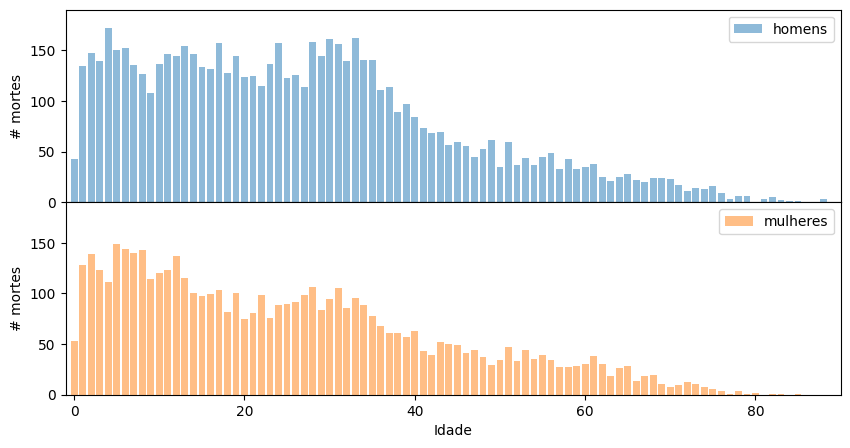

In [94]:
# Vamos visualizar os dados novamente em um gráfico:
pl.figure(figsize=(10,5))
ag.graf_barra_2(limpo_por_idade_df, ylabel='# mortes', ylim=[0,190])
pl.xlabel('Idade')
pl.show()

### Exportando os dados limpos

Vamos exportar os dados acima para um arquivo CSV, para poder começar a análise num novo notebook:

In [95]:
# Exporta os dados limpos:
#limpo_por_idade_df.to_csv('dados/mortos-em-gaza_nomes-contabilizados_limpo.csv')

<center>
    <img src="https://nucleodetecnologia.com.br/assets/img/novo-logo-tecnologia.svg?bl=tutorial-gaza-20" width="150">
</center>